In [ ]:
!nvidia-smi

Tue Feb  9 19:16:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!pip install librosa tensorboardX wandb -U

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4MB 23kB/s 
     |████████████████████████████████| 12.8MB 250kB/s 
     |████████████████████████████████| 7.6MB 8.0MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
Requirement already up-to-date: librosa in /usr/local/lib/python3.6/dist-packages (0.8.0)
     |████████████████████████████████| 317kB 14.5MB/s 
     |████████████████████████████████| 2.0MB 48.5MB/s 
     |████████████████████████████████| 102kB 15.0MB/s 
     |████████████████████████████████| 133kB 53.6MB/s 
     |████████████████████████████████| 163kB 54.6MB/s 
     |████████████████████████████████| 71kB 12.6MB/s 
  Created wheel for subprocess32: filename=subprocess

In [ ]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchaudio
import numpy as np
import wandb
from torch.utils.data import DataLoader, Dataset
from itertools import cycle, islice
import librosa
import pandas as pd
from PIL import Image
from tqdm import tqdm
import os
import shutil
from tensorboardX import SummaryWriter

In [ ]:
# !sudo apt-get install pigz axel

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pigz -dc drive/My\ Drive/UrbanSound8K.tar.gz | tar xf - -C ./
# alternatively, download the dataset from this HTTP url:
# !wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
# and extract:
# !tar -xf ./UrbanSound8K.tar.gz

In [ ]:
params = {
	"dataset_name": "UrbanSound8K",
	"data_dir": "./UrbanSound8K",

  "n_fft": 2205,
  "window_sizes": [25, 50, 100],
  "hop_sizes": [10, 25, 50],
  "n_mels": 128,

	"dataaug": True,
	"pretrained": True,
	"scheduler": True,
	"architecture": "resnet50_2_wide",
	"batch_size": 64,
	"num_workers": 4,
	"epochs": 70,
	"lr": 1e-4,
  "weight_decay": 1e-3,
  "val_fold": 10,
  "checkpoint_dir": "./"
}

In [ ]:
#df = pd.read_csv(f"{params['data_dir']}/metadata/UrbanSound8K.csv")
!wget http://76.213.149.126:8081/UrbanSound8K/metadata/UrbanSound8K.csv
df = pd.read_csv("./UrbanSound8K.csv")
df

--2021-02-09 19:19:59--  http://76.213.149.126:8081/UrbanSound8K/metadata/UrbanSound8K.csv
Connecting to 76.213.149.126:8081... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494104 (483K) [text/csv]
Saving to: ‘UrbanSound8K.csv’

UrbanSound8K.csv    100%[===================>] 482.52K  2.14MB/s    in 0.2s    

2021-02-09 19:20:00 (2.14 MB/s) - ‘UrbanSound8K.csv’ saved [494104/494104]



,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# contain dataset for both train and validation sets for easier
# loading and changing folds. Changing folds for validation won't
# require the data to be modified since everything is stored together.
shared_data_memory = {}

import pickle
for x in range(0, 9):
  with open(f"/content/drive/MyDrive/UrbanSound8K_extracted_{x}.pkl", "rb") as rb:
    stored_dict = pickle.load(rb)
    for a in stored_dict:
      shared_data_memory[a] = stored_dict[a].copy()
    del stored_dict
    print(f"Finished loading UrbanSound8K_extracted_{x}.pkl")

print(len(shared_data_memory))

Finished loading UrbanSound8K_extracted_0.pkl
Finished loading UrbanSound8K_extracted_1.pkl
Finished loading UrbanSound8K_extracted_2.pkl
Finished loading UrbanSound8K_extracted_3.pkl
Finished loading UrbanSound8K_extracted_4.pkl
Finished loading UrbanSound8K_extracted_5.pkl
Finished loading UrbanSound8K_extracted_6.pkl
Finished loading UrbanSound8K_extracted_7.pkl
Finished loading UrbanSound8K_extracted_8.pkl
8732


In [ ]:
class UrbanSoundDataset(Dataset):
    # wrapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csv_path, file_path, folderList):
        csvData = pd.read_csv(csv_path)
        #initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []
        self.folders = []
        #loop through the csv entries and only add entries from folders in the folder list
        for i in range(0,len(csvData)):
            if csvData.iloc[i, 5] in folderList:
                self.file_names.append(csvData.iloc[i, 0])
                self.labels.append(csvData.iloc[i, 6])
                self.folders.append(csvData.iloc[i, 5])
                
        self.file_path = file_path
        #self.mixer = torchaudio.transforms.DownmixMono() # Convert stereo audio to mono
        self.folderList = folderList
        self.num_channels = 3
        self.window_sizes = params["window_sizes"]
        self.hop_sizes =  params["hop_sizes"]
        self.data_memory = shared_data_memory
        self.normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

    def __getitem__(self, index):
        # see https://github.com/pytorch/audio/issues/80 for torchaudio vs librosa

        # format the file path and load the file
        path = self.file_path + "fold" + str(self.folders[index]) + "/" + self.file_names[index]
        if path in self.data_memory:
          return self.data_memory[path]["spec"], self.data_memory[path]["label"]
        else:
          sound, sr = torchaudio.load(path, out = None, normalization = True)
          soundData = torch.mean(sound, dim=0, keepdim=True)
          # downsample the audio to 22.5khz
          soundData = torchaudio.transforms.Resample(sr, 22050).forward(soundData)
          # pad to 4 seconds
          # Ommited for now to reproduce a paper

          num_channels = 3
          window_sizes = params["window_sizes"]
          hop_sizes = params["hop_sizes"]
          spec = self.extract_spectrogram(soundData, 22050)
          spec -= spec.min()
          spec /= spec.max()
          spec = self.normalize(spec)
          self.data_memory[path] = {}
          self.data_memory[path]["spec"] = spec
          self.data_memory[path]["label"] = self.labels[index]

          return spec, self.labels[index]
    
    def __len__(self):
        return len(self.file_names)

    def extract_spectrogram(self, waveform, sr):
      specs = []
      for i in range(self.num_channels):
          window_length = int(round(self.window_sizes[i]*sr/1000))
          hop_length = int(round(self.hop_sizes[i]*sr/1000))

          spec = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=params["n_fft"], win_length=window_length, hop_length=hop_length, n_mels=params["n_mels"])(waveform)
          eps = 1e-6
          spec = torch.log(spec + eps)
          spec = torchvision.transforms.Resize((128, 250))(spec)
          specs.append(torch.squeeze(spec))
      return torch.stack(specs)
        
#csv_path = f'{params["data_dir"]}/metadata/UrbanSound8K.csv'
csv_path = './UrbanSound8K.csv'

file_path = f'{params["data_dir"]}/audio/'

train_folds = list(range(1, 11))
train_folds.remove(params["val_fold"])
train_set = UrbanSoundDataset(csv_path, file_path, train_folds)
test_set = UrbanSoundDataset(csv_path, file_path, [params["val_fold"]])
print("Train set size: " + str(len(train_set)))
print("Test set size: " + str(len(test_set)))

kwargs = {'num_workers': params["num_workers"], 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu

train_loader = torch.utils.data.DataLoader(train_set, batch_size = params["batch_size"], shuffle = True, **kwargs)
val_loader = torch.utils.data.DataLoader(test_set, batch_size = params["batch_size"], shuffle = True, **kwargs)

Train set size: 7895
Test set size: 837


In [ ]:
i = iter(train_loader)
print(i.next())

/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


[tensor([[[[-6.8166e-01, -4.5032e+00, -3.0743e+00,  ...,  3.3758e-01,
            2.8858e-01, -2.3350e-01],
          [-9.7949e-01, -3.4104e+00, -3.1573e+00,  ...,  1.0079e+00,
            1.7070e-01,  6.8758e-01],
          [-1.6140e+00, -2.6330e+00, -2.1678e+00,  ...,  1.2005e+00,
           -4.3105e-01,  6.4746e-01],
          ...,
          [-7.6560e+00, -7.5572e+00, -7.6343e+00,  ..., -4.6284e+00,
           -3.3127e+00, -3.1870e+00],
          [-7.4520e+00, -7.3979e+00, -7.6836e+00,  ..., -2.7687e+00,
           -4.0421e+00, -3.3307e+00],
          [-7.7954e+00, -7.2673e+00, -7.2583e+00,  ..., -1.3663e+00,
           -2.4911e+00, -2.9118e+00]],

         [[ 2.3642e-01, -1.1577e+00, -2.5773e+00,  ...,  6.4902e-01,
            1.1752e+00,  1.5650e+00],
          [-3.7848e-01, -1.5683e+00, -2.8956e+00,  ...,  1.8740e+00,
            1.8352e+00,  1.7841e+00],
          [-1.1909e+00, -2.6307e+00, -4.1654e+00,  ...,  1.8210e+00,
            9.6490e-01,  2.3304e-01],
          ...,
    

torch.Size([3, 128, 250])


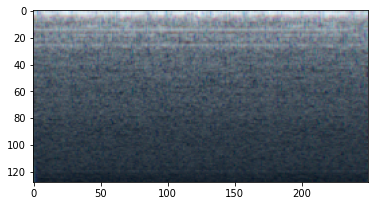

In [ ]:
import matplotlib.pyplot as plt

t = next(i)[0][0]
t = (t - t.min()) * 255 / (t.max() - t.min())
t = t.squeeze()
t = t.type(torch.IntTensor)
print(t.size())
plt.imshow(t.permute(1, 2, 0))

In [ ]:
import torchvision.models as models

class ResNet(nn.Module):
  def __init__(self, dataset):
    super(ResNet, self).__init__()
    num_classes = 50 if dataset=="ESC" else 10
    self.model = models.wide_resnet50_2(pretrained=params["pretrained"])
    #print(self.model)
    self.model.fc = nn.Linear(2048, num_classes)
		
  def forward(self, x):
    output = self.model(x)
    return output

In [ ]:
class RunningAverage():
	def __init__(self):
		self.total = 0
		self.steps = 0
	def update(self, loss):
		self.total += loss
		self.steps += 1
	def __call__(self):
		return (self.total/float(self.steps))

def save_checkpoint(state, is_best, split, checkpoint):
  filename = os.path.join(checkpoint, 'last{}.pth.tar'.format(split))
  if not os.path.exists(checkpoint):
    print("Checkpoint Directory does not exist")
    os.mkdir(checkpoint)
  torch.save(state, filename)
  if is_best:
    shutil.copyfile(filename, os.path.join(checkpoint, "model_best_{}.pth.tar".format(split)))

def train(model, device, data_loader, optimizer, loss_fn, epoch=1):
    model.train()
    loss_avg = RunningAverage()

    with tqdm(total=len(data_loader)) as t:
        for batch_idx, data in enumerate(data_loader):
            inputs = data[0].to(device)
            target = data[1].to(device)

            outputs = model(inputs)

            loss = loss_fn(outputs, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg.update(loss.item())
            wandb.log({"avg_loss": loss_avg(), "batch": batch_idx})
            wandb.log({"batch_loss": loss.item(), "batch": batch_idx})

            t.set_postfix(loss='{:05.3f}'.format(loss_avg()))
            t.update()
    return loss_avg()

def evaluate(model, device, test_loader):
  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
    for batch_idx, data in enumerate(test_loader):
      inputs = data[0].to(device)
      target = data[1].to(device)

      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()

  return (100*correct/total)

def train_and_evaluate(model, device, train_loader, val_loader, optimizer, loss_fn, writer, params, split, scheduler=None):
    best_acc = 0.0

    for epoch in range(params["epochs"]):
        avg_loss = train(model, device, train_loader, optimizer, loss_fn, epoch=epoch)

        acc = evaluate(model, device, val_loader)
        print("Epoch {}/{} Loss:{} Valid Acc:{}".format(epoch, params["epochs"], avg_loss, acc))
        wandb.log({"epoch_avg_loss": avg_loss, 'epoch': epoch})
        wandb.log({"epoch_val_acc": acc, 'epoch': epoch})

        is_best = (acc > best_acc)
        if is_best:
            best_acc = acc
        if scheduler:
            scheduler.step()

        save_checkpoint({"epoch": epoch + 1,
                               "model": model.state_dict(),
                               "optimizer": optimizer.state_dict()}, is_best, split, "{}".format(params["checkpoint_dir"]))
        writer.add_scalar("data{}/trainingLoss{}".format(params["dataset_name"], split), avg_loss, epoch)
        writer.add_scalar("data{}/valLoss{}".format(params["dataset_name"], split), acc, epoch)
    writer.close()

model = ResNet("US8K").to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
writer = SummaryWriter(comment="US8K")
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 30, gamma=0.1)

In [ ]:
wandb.init(project="audio-classification", config = params)
wandb.watch(model, log_freq = len(train_loader))

avg_loss,0.00026
batch,123
_runtime,1408
_timestamp,1612901341
_step,17499
batch_loss,0.00339
epoch_avg_loss,0.00026
epoch,69
epoch_val_acc,85.66308


avg_loss,█▅▂▃▂▂▁▂▃▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch,▁▁▂▂▂▃▃▄▄▅▅▅▆▆▆▇▇██▁▁▂▂▃▃▄▄▄▅▅▅▆▆▇▇██▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch_loss,█▃▁▂▃▁▁▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_avg_loss,█▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch_val_acc,▆▇▇▆█▅▇▇▁█▇▇█▇█▇████████████████████████


In [ ]:
train_and_evaluate(model, device, train_loader, val_loader, optimizer, loss_fn, writer, params, 1, scheduler)

100%|██████████| 124/124 [01:36<00:00,  1.28it/s, loss=0.515]


Epoch 0/70 Loss:0.5148765497630642 Valid Acc:83.03464755077658


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.114]


Epoch 1/70 Loss:0.11434362714569415 Valid Acc:83.03464755077658


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.065]


Epoch 2/70 Loss:0.06545678939249727 Valid Acc:82.79569892473118


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, loss=0.059]


Epoch 3/70 Loss:0.0590525618378794 Valid Acc:82.31780167264039


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.043]


Epoch 4/70 Loss:0.043336416027628846 Valid Acc:85.30465949820788


100%|██████████| 124/124 [01:44<00:00,  1.19it/s, loss=0.044]


Epoch 5/70 Loss:0.043596932917998564 Valid Acc:81.24253285543608


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, loss=0.041]


Epoch 6/70 Loss:0.04118604909050309 Valid Acc:82.55675029868578


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, loss=0.027]


Epoch 7/70 Loss:0.027037577210707712 Valid Acc:80.88410991636798


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.043]


Epoch 8/70 Loss:0.042588426973745826 Valid Acc:84.34886499402629


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, loss=0.039]


Epoch 9/70 Loss:0.03891826393890135 Valid Acc:79.21146953405018


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.041]


Epoch 10/70 Loss:0.041030620138401225 Valid Acc:82.91517323775388


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.056]


Epoch 11/70 Loss:0.055814600055811986 Valid Acc:82.55675029868578


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, loss=0.031]


Epoch 12/70 Loss:0.030592803772906924 Valid Acc:81.00358422939068


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, loss=0.019]


Epoch 13/70 Loss:0.019476599352914962 Valid Acc:79.56989247311827


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, loss=0.017]


Epoch 14/70 Loss:0.017256508051838364 Valid Acc:85.42413381123059


100%|██████████| 124/124 [01:44<00:00,  1.19it/s, loss=0.016]


Epoch 15/70 Loss:0.01599487674238551 Valid Acc:81.36200716845879


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, loss=0.061]


Epoch 16/70 Loss:0.06117332558290312 Valid Acc:80.40621266427718


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, loss=0.044]


Epoch 17/70 Loss:0.044437729729144206 Valid Acc:85.54360812425328


100%|██████████| 124/124 [01:44<00:00,  1.19it/s, loss=0.054]


Epoch 18/70 Loss:0.05410849453220444 Valid Acc:83.51254480286738


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.044]


Epoch 19/70 Loss:0.04359886917706218 Valid Acc:88.2915173237754


100%|██████████| 124/124 [01:44<00:00,  1.19it/s, loss=0.014]


Epoch 20/70 Loss:0.01428530425924222 Valid Acc:82.91517323775388


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.034]


Epoch 21/70 Loss:0.033847003086139596 Valid Acc:82.07885304659499


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, loss=0.018]


Epoch 22/70 Loss:0.017869123702703583 Valid Acc:81.24253285543608


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.016]


Epoch 23/70 Loss:0.016023000814921914 Valid Acc:83.27359617682198


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, loss=0.013]


Epoch 24/70 Loss:0.012905436966966296 Valid Acc:80.88410991636798


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.053]


Epoch 25/70 Loss:0.05339884320029899 Valid Acc:81.48148148148148


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.069]


Epoch 26/70 Loss:0.06874223545403971 Valid Acc:80.64516129032258


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.030]


Epoch 27/70 Loss:0.030395457669416624 Valid Acc:84.10991636798089


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.024]


Epoch 28/70 Loss:0.024051049129000954 Valid Acc:84.82676224611708


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.022]


Epoch 29/70 Loss:0.02174882078449422 Valid Acc:83.39307048984469


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.006]


Epoch 30/70 Loss:0.006434061094149647 Valid Acc:84.46833930704898


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.004]


Epoch 31/70 Loss:0.0035816661850643166 Valid Acc:83.39307048984469


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.004]


Epoch 32/70 Loss:0.0037431068192217347 Valid Acc:84.10991636798089


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.002]


Epoch 33/70 Loss:0.0023633150875309273 Valid Acc:84.34886499402629


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, loss=0.002]


Epoch 34/70 Loss:0.0018710165590633669 Valid Acc:84.70728793309438


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.002]


Epoch 35/70 Loss:0.001657691988868699 Valid Acc:83.87096774193549


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, loss=0.002]


Epoch 36/70 Loss:0.0017226661901429084 Valid Acc:83.99044205495818


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, loss=0.001]


Epoch 37/70 Loss:0.001458740244655224 Valid Acc:85.06571087216248


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, loss=0.001]


Epoch 38/70 Loss:0.0011378535245087059 Valid Acc:85.66308243727599


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 39/70 Loss:0.001054151941301121 Valid Acc:85.30465949820788


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 40/70 Loss:0.0010261323625473456 Valid Acc:84.58781362007169


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 41/70 Loss:0.001025744611040629 Valid Acc:84.46833930704898


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 42/70 Loss:0.0009789845623139803 Valid Acc:85.30465949820788


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.002]


Epoch 43/70 Loss:0.001676653366068363 Valid Acc:85.42413381123059


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 44/70 Loss:0.0009006881732456086 Valid Acc:86.14097968936679


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 45/70 Loss:0.0008405710102505832 Valid Acc:86.26045400238948


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 46/70 Loss:0.0010496159018422927 Valid Acc:84.94623655913979


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 47/70 Loss:0.0009693947562951625 Valid Acc:85.06571087216248


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 48/70 Loss:0.00087188433990964 Valid Acc:85.30465949820788


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 49/70 Loss:0.0009313098161064479 Valid Acc:86.37992831541219


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 50/70 Loss:0.0008104490261757746 Valid Acc:86.14097968936679


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 51/70 Loss:0.0011051043517410666 Valid Acc:85.78255675029868


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 52/70 Loss:0.0006949756045228682 Valid Acc:84.82676224611708


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, loss=0.001]


Epoch 53/70 Loss:0.0008875805900559851 Valid Acc:84.94623655913979


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 54/70 Loss:0.0007997650841829337 Valid Acc:86.73835125448029


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 55/70 Loss:0.0011556074493836927 Valid Acc:85.90203106332139


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 56/70 Loss:0.0010607860761322832 Valid Acc:86.37992831541219


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 57/70 Loss:0.0008192041279999689 Valid Acc:86.14097968936679


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 58/70 Loss:0.0013327914965620654 Valid Acc:85.42413381123059


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 59/70 Loss:0.0012048758470618556 Valid Acc:86.37992831541219


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, loss=0.002]


Epoch 60/70 Loss:0.001895773517213867 Valid Acc:86.02150537634408


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 61/70 Loss:0.0007496003583524256 Valid Acc:86.37992831541219


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 62/70 Loss:0.0007272830201057537 Valid Acc:86.4994026284349


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 63/70 Loss:0.0007189503580335558 Valid Acc:86.61887694145759


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 64/70 Loss:0.0006915799270744526 Valid Acc:86.4994026284349


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 65/70 Loss:0.0010502068194440536 Valid Acc:85.54360812425328


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 66/70 Loss:0.0006821607814579752 Valid Acc:86.4994026284349


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 67/70 Loss:0.0007630632568297217 Valid Acc:85.90203106332139


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 68/70 Loss:0.0006529404953095852 Valid Acc:85.54360812425328


100%|██████████| 124/124 [01:43<00:00,  1.20it/s, loss=0.001]


Epoch 69/70 Loss:0.0006292578739615442 Valid Acc:87.21624850657109


In [ ]:
import pickle

with open('./UrbanSound8K_extracted.pkl', 'wb') as wb:
  pickle.dump(shared_data_memory, wb)

In [ ]:
train(model, device, train_loader, optimizer, loss_fn)

  0%|          | 0/124 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)
100%|██████████| 124/124 [11:17<00:00,  5.47s/it, loss=0.539]


0.5392406314250923

In [ ]:
!ls -alh

total 3.7G
drwxr-xr-x 1 root       root       4.0K Jan 31 21:43 .
drwxr-xr-x 1 root       root       4.0K Jan 31 21:09 ..
drwxr-xr-x 1 root       root       4.0K Jan 28 17:15 .config
drwx------ 6 root       root       4.0K Jan 31 21:16 drive
-rw-r--r-- 1 root       root       270M Jan 31 21:39 last1.pth.tar
-rw-r--r-- 1 root       root       270M Jan 31 21:39 model_best_1.pth.tar
drwxr-xr-x 3 root       root       4.0K Jan 31 21:23 runs
drwxr-xr-x 1 root       root       4.0K Jan 20 17:27 sample_data
drwx--x--x 4 1829600028 1829600028 4.0K Jun  3  2014 UrbanSound8K
-rw-r--r-- 1 root       root       367M Jan 31 21:42 UrbanSound8K_extracted_0.pkl
-rw-r--r-- 1 root       root       367M Jan 31 21:42 UrbanSound8K_extracted_1.pkl
-rw-r--r-- 1 root       root       367M Jan 31 21:42 UrbanSound8K_extracted_2.pkl
-rw-r--r-- 1 root       root       367M Jan 31 21:42 UrbanSound8K_extracted_3.pkl
-rw-r--r-- 1 root       root       367M Jan 31 21:42 UrbanSound8K_extracted_4.pkl
-rw-r--r-- 1 root 

In [ ]:
a = [list(shared_data_memory.keys())[i:i + 1000] for i in range(0, len(shared_data_memory.keys()), 1000)]

In [ ]:
i = 0
import pickle

for x in a:
  new_dict = {}
  for b in x:
    new_dict[b] = shared_data_memory[b].copy()
  with open(f'./UrbanSound8K_extracted_{i}.pkl', 'wb') as wb:
    pickle.dump(new_dict, wb, protocol=pickle.HIGHEST_PROTOCOL)
  i += 1

In [ ]:
!rm -rf *.pkl

In [ ]:
shared_data_memory

{'./UrbanSound8K/audio/fold7/130961-4-3-0.wav': {'label': 4,
  'spec': tensor([[[ 2.2849,  0.5804,  1.4386,  ...,  0.1861, -0.8464, -0.9881],
           [ 2.6158,  1.5546,  1.7899,  ...,  1.1949,  0.6578, -0.2296],
           [ 2.6152,  1.7790,  1.8582,  ...,  2.0186,  1.6000,  1.0367],
           ...,
           [-3.5256, -2.4596, -2.5203,  ..., -2.4621, -1.6262, -1.6301],
           [-3.2161, -2.7403, -3.1414,  ..., -1.7967, -2.0389, -1.7187],
           [-3.7463, -3.1622, -2.9088,  ..., -1.3468, -3.0191, -1.3935]],
  
          [[ 1.8854,  1.9042,  1.7799,  ..., -1.3497, -0.5789,  0.2426],
           [ 3.4633,  3.2792,  2.7456,  ..., -0.4504, -0.7182, -0.7496],
           [ 3.7303,  3.3179,  2.7122,  ...,  1.4689,  1.3032,  1.1454],
           ...,
           [-2.8698, -2.3600, -1.7450,  ..., -1.2056, -0.6625, -0.2688],
           [-2.4656, -2.3322, -2.2185,  ..., -1.2895, -0.8752, -0.5143],
           [-2.8778, -2.5390, -2.1551,  ..., -1.5476, -1.0386, -0.5059]],
  
          [[ 1.

In [ ]:
!cp *.pkl /content/drive/MyDrive/

In [ ]:
!rm /content/drive/MyDrive/UrbanSound8K_extracted*